# Fase 1: Importación de librerías necesarias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ------------------------------
# MÓDULOS PARA MANIPULACIÓN Y VISUALIZACIÓN DE DATOS
# ------------------------------
import numpy as np  # Operaciones numéricas de alto rendimiento
import pandas as pd  # Manipulación de datos estructurados (opcional si se usa DataFrame)
import matplotlib.pyplot as plt  # Visualización de métricas y resultados
import seaborn as sns  # Visualizaciones más atractivas
import re

# ------------------------------
# MÓDULOS DE PREPROCESAMIENTO Y UTILIDADES DE KERAS
# ------------------------------
from tensorflow.keras.datasets import imdb  # Dataset IMDB preprocesado de Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding para secuencias
from tensorflow.keras.preprocessing.text import Tokenizer  # (Si decides usar texto original en lugar de índices)
# ------------------------------
# MÓDULOS PARA DEFINIR EL MODELO EN KERAS
# ------------------------------
from tensorflow.keras.models import Model  # API funcional para modelos complejos
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Add, Embedding
# ------------------------------
# MÓDULOS DE LA ARQUITECTURA TRANSFORMER (capas de atención y más)
# ------------------------------
from tensorflow.keras.layers import MultiHeadAttention  # Mecanismo de atención multiparte
from tensorflow.keras.optimizers import Adam  # Optimizador popular en NLP
from tensorflow.keras.losses import BinaryCrossentropy  # Pérdida para clasificación binaria
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, Callback
# ------------------------------
# MÓDULOS PARA MÉTRICAS Y ANÁLISIS
# ------------------------------
from sklearn.metrics import classification_report, confusion_matrix  # Métricas de rendimiento
from sklearn.model_selection import train_test_split
# ------------------------------
# UTILIDADES ADICIONALES
# ------------------------------
import tensorflow as tf  # Librería base para modelos de deep learning
import os  # Para gestionar rutas de guardado de modelos/logs

# Fase 2: Exploración del Dataset IMDB

In [ ]:
# Cargamos el dataset IMDB desde Keras.
# Este dataset ya viene tokenizado: las palabras han sido reemplazadas por índices enteros.
# num_words=10000 indica que se conservarán las 10,000 palabras más frecuentes.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Revisamos la cantidad de muestras en entrenamiento y prueba
print("Tamaño del set de entrenamiento:", len(X_train))
print("Tamaño del set de prueba:", len(X_test))

Tamaño del set de entrenamiento: 25000
Tamaño del set de prueba: 25000


In [ ]:
# Mostramos una reseña en su forma tokenizada (índices de palabras)
print("Ejemplo de reseña (tokenizada):", X_train[0])

# Mostramos la etiqueta asociada (0 = negativa, 1 = positiva)
print("Etiqueta de la reseña:", y_train[0])

Ejemplo de reseña (tokenizada): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Etiqueta de la reseña: 1


In [ ]:
# Calculamos la longitud de cada reseña
review_lengths = [len(review) for review in X_train]

# Estadísticas descriptivas sobre la longitud de las reseñas
print("Longitud mínima:", np.min(review_lengths))
print("Longitud máxima:", np.max(review_lengths))
print("Longitud promedio:", np.mean(review_lengths))

Longitud mínima: 11
Longitud máxima: 2494
Longitud promedio: 238.71364


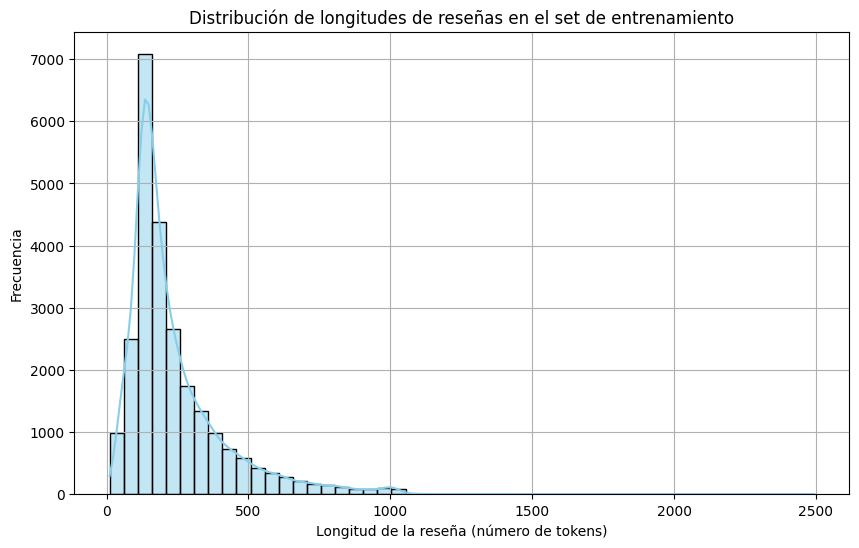

In [ ]:
# Visualizamos la distribución de las longitudes para decidir un valor razonable de padding
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50, kde=True, color='skyblue')
plt.title("Distribución de longitudes de reseñas en el set de entrenamiento")
plt.xlabel("Longitud de la reseña (número de tokens)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [ ]:
# Obtenemos el diccionario que mapea palabras a índices
word_index = imdb.get_word_index()

# Revertimos el diccionario: de índice a palabra
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "[PAD]"
index_to_word[1] = "[START]"
index_to_word[2] = "[UNK]"
index_to_word[3] = "[UNUSED]"

# Función para decodificar una reseña
def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i, "?") for i in encoded_review])

# Visualizamos la reseña decodificada
print("Reseña decodificada:\n", decode_review(X_train[0]))

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Reseña decodificada:
 [START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the 

# Fase 3: Preprocesamiento del Dataset IMDB

Paso 1: Definir la longitud máxima de las secuencias

In [ ]:
# Longitud máxima de las reseñas para padding/truncamiento
MAX_LEN = 250  # Puedes ajustarlo si quieres probar con más/menos contexto

Paso 2: Aplicar padding a las secuencias

In [ ]:
# Pad o trunca las reseñas para que todas tengan la misma longitud
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

# Verificamos que todas las reseñas ahora tengan la misma longitud
print("Nueva forma de las reseñas:", X_train_pad.shape)

Nueva forma de las reseñas: (25000, 250)


Paso 3: Conversión de etiquetas a float32

In [ ]:
# Convertimos las etiquetas a float32 para compatibilidad con la función de pérdida
y_train = np.array(y_train).astype("float32")
y_test = np.array(y_test).astype("float32")

Paso 4: Crear un conjunto de validación

In [ ]:
# Separamos un pequeño conjunto de validación del set de entrenamiento
X_train_pad, X_val_pad, y_train, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.15, random_state=42)

print("Train shape:", X_train_pad.shape)
print("Validation shape:", X_val_pad.shape)

Train shape: (21250, 250)
Validation shape: (3750, 250)


Paso 5: Revisar una reseña tras el padding

In [ ]:
# Mostrar la reseña decodificada después del padding
print("Reseña con padding:\n", decode_review(X_train_pad[0]))

Reseña con padding:
 [START] i love buying those cheap lousy dvd's from [UNK] video one day i happened to buy this one it's the perfect silly science fiction film of the 50's all [UNK] up [UNK] with [UNK] everything scantily clad girls and plenty of melodrama it's an enjoyable film to those who appreciate this kind of stuff and if you can [UNK] your [UNK] enough you can actually get [UNK] out not just by the psychotic head or by the beating of the thing in the closet but toward the end with the character of 'the perfect [UNK] it's so what's another word for [UNK] ing [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## 3.1 Validación de los Datos Procesados

1. Verificar la distribución de clases (positivas vs negativas)

Negativa: 10686 muestras
Positiva: 10564 muestras


/tmp/ipython-input-14-90149018.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


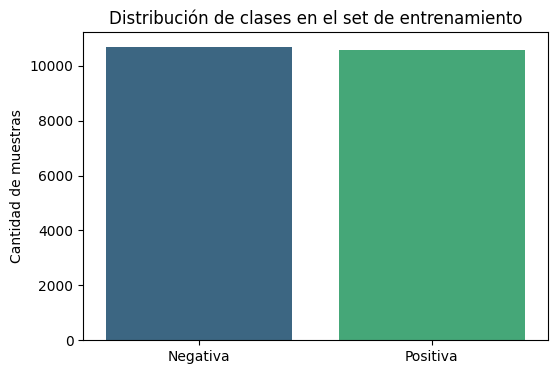

In [ ]:
# Conteo de clases en el set de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)

# Mapeo a etiquetas legibles
labels = ['Negativa', 'Positiva']
for label, count in zip(labels, counts):
    print(f"{label}: {count} muestras")

# Visualización con gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=counts, palette='viridis')
plt.title("Distribución de clases en el set de entrenamiento")
plt.ylabel("Cantidad de muestras")
plt.show()

2. Confirmar que todas las secuencias tengan el mismo largo

In [ ]:
# Verificamos que todas las secuencias sean de longitud MAX_LEN
train_lengths = [len(seq) for seq in X_train_pad]
print("¿Todas las reseñas tienen longitud MAX_LEN?:", all(l == MAX_LEN for l in train_lengths))

¿Todas las reseñas tienen longitud MAX_LEN?: True


3. Mostrar un ejemplo post-padding y su etiqueta

In [ ]:
# Seleccionamos una reseña y mostramos su contenido
idx = 1
print("Etiqueta:", "Positiva" if y_train[idx] == 1.0 else "Negativa")
print("Secuencia tokenizada (con padding):\n", X_train_pad[idx])

# Decodificamos (excluyendo ceros del padding para mayor claridad)
print("Reseña decodificada:\n", decode_review([i for i in X_train_pad[idx] if i != 0]))

Etiqueta: Negativa
Secuencia tokenizada (con padding):
 [   1   48   13 1869  332   27  403   23    4  288 1108   13  115   62
   28 6677   15   14  247    2    5  154 3357  621   16   93   34    6
  132   38 3280 3445   19    4  785  162 2869   11  192    4   22    9
   38  230   39   15   15   13  594   48  145   11    4 4867    5 3352
  162 2869    2   62   28  427 1800   14  552    7   22   45   38   38
 4928    5   12  186    8   28  117    8   81   19   38  111    7   27
  960  108   14  218 2707    6   78  155   43    6   55 1767  155   10
   10   51   13   82  258    6  227 1767   16    4 1166    7 2822   49
    7    4 1989  520   14   22  262   54   50   26   38  111  128  785
 2769   46   50    4  690   11   14   22   71  331   24  572  221    5
    4  105   32  468   38 1904    5 2749   48   13   69    8   67  160
 1026  415   37    2   44   89  254   12    9    8   30 1026   42   79
    6   52 6388 1866   23    6 5417 4267   13   16  170    8    2   10
   10    4 1324  347 

4. Comprobar distribución de clases en validación y test

In [ ]:
# Validación
val_labels, val_counts = np.unique(y_val, return_counts=True)
print("Distribución en Validación:", dict(zip(val_labels, val_counts)))

# Test
test_labels, test_counts = np.unique(y_test, return_counts=True)
print("Distribución en Test:", dict(zip(test_labels, test_counts)))

Distribución en Validación: {np.float32(0.0): np.int64(1814), np.float32(1.0): np.int64(1936)}
Distribución en Test: {np.float32(0.0): np.int64(12500), np.float32(1.0): np.int64(12500)}


5. Confirmar tipos y dimensiones finales

In [ ]:
print("Tipo de datos de X_train_pad:", X_train_pad.dtype)
print("Forma de X_train_pad:", X_train_pad.shape)
print("Forma de y_train:", y_train.shape)

Tipo de datos de X_train_pad: int32
Forma de X_train_pad: (21250, 250)
Forma de y_train: (21250,)


# Fase 4: Diseño del Modelo Transformer Encoder-Decoder

In [ ]:
# Dimensiones del modelo Transformer
VOCAB_SIZE = 10000        # Número de palabras únicas
MAX_LEN = 250             # Longitud máxima de las secuencias (ya definido)
EMBED_DIM = 128           # Dimensión del embedding
NUM_HEADS = 4             # Número de cabezas de atención
FF_DIM = 128              # Dimensión interna del feed-forward
NUM_ENCODER_BLOCKS = 2    # Número de bloques en el encoder
NUM_DECODER_BLOCKS = 2    # Número de bloques en el decoder
DROPOUT_RATE = 0.1

In [ ]:
# Capa de embedding con mask_zero=True para soportar padding
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            input_length=MAX_LEN,
                            mask_zero=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Bloque del encoder
def transformer_encoder(inputs):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention = Dropout(DROPOUT_RATE)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward
    ff = Dense(FF_DIM, activation="relu")(out1)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out1 + ff)

# Bloque del decoder (simplificado para clasificación)
def transformer_decoder(inputs, encoder_output):
    # Masked self-attention del decoder
    attention1 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention1 = Dropout(DROPOUT_RATE)(attention1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)

    # Atención sobre la salida del encoder
    attention2 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(out1, encoder_output)
    attention2 = Dropout(DROPOUT_RATE)(attention2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attention2)

    # Feed-forward
    ff = Dense(FF_DIM, activation="relu")(out2)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out2 + ff)

In [ ]:
# Input del encoder y decoder
encoder_inputs = Input(shape=(MAX_LEN,), name="encoder_input")
decoder_inputs = Input(shape=(MAX_LEN,), name="decoder_input")

# Embedding compartido para encoder y decoder
x_enc = embedding_layer(encoder_inputs)
x_dec = embedding_layer(decoder_inputs)

# Aplicamos bloques encoder
for _ in range(NUM_ENCODER_BLOCKS):
    x_enc = transformer_encoder(x_enc)

# Aplicamos bloques decoder
for _ in range(NUM_DECODER_BLOCKS):
    x_dec = transformer_decoder(x_dec, x_enc)

# Pooling + Capa de salida
x = GlobalAveragePooling1D()(x_dec)
x = Dropout(DROPOUT_RATE)(x)
outputs = Dense(1, activation="sigmoid")(x)

# Modelo final
transformer_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

In [ ]:
# Resumen del modelo
transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  1,280,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 250)       │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 250, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 250, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 128)  │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 250, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 250)       │          0 │ decoder_input[0]

 Total params: 2,997,633 (11.44 MB)

 Trainable params: 2,997,633 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
transformer_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=["accuracy"]
)

# Fase 5: Entrenamiento del Modelo Transformer

In [ ]:
# Rutas definidas
CHECKPOINT_DIR = "/content/drive/MyDrive/Transformer/Checkpoint"
LOG_DIR = "/content/drive/MyDrive/Transformer/Log"
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.h5")
EPOCH_TRACKER_PATH = os.path.join(CHECKPOINT_DIR, "last_epoch.txt")

In [ ]:
# ⚠️ Validación robusta de existencia y contenido
def is_checkpoint_valid(model_path):
    return os.path.isfile(model_path) and os.path.getsize(model_path) > 0

def is_epoch_file_valid(epoch_path):
    return os.path.isfile(epoch_path) and os.path.getsize(epoch_path) > 0

# Epoch inicial
initial_epoch = 0

# Cargar pesos si ambos archivos son válidos
if is_checkpoint_valid(CHECKPOINT_PATH) and is_epoch_file_valid(EPOCH_TRACKER_PATH):
    try:
        print("✅ Checkpoint encontrado. Intentando cargar pesos del modelo...")
        transformer_model.load_weights(CHECKPOINT_PATH)
        with open(EPOCH_TRACKER_PATH, "r") as f:
            initial_epoch = int(f.read().strip()) + 1
        print(f"Reanudando desde la época {initial_epoch}")
    except Exception as e:
        print("⚠️ Error al cargar los pesos del checkpoint. Se ignorará y se entrenará desde cero.")
        print(f"Detalles del error: {e}")
        initial_epoch = 0
else:
    print("ℹ️ No se encontró checkpoint válido. Entrenamiento comenzará desde la época 0.")

ℹ️ No se encontró checkpoint válido. Entrenamiento comenzará desde la época 0.


In [ ]:
# Callback personalizado para guardar el número de la última época completada
class EpochTrackerCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(EPOCH_TRACKER_PATH, "w") as f:
            f.write(str(epoch))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=LOG_DIR),
    EpochTrackerCallback()
]

In [ ]:
history = transformer_model.fit(
    [X_train_pad, X_train_pad],   # input_encoder, input_decoder
    y_train,
    validation_data=([X_val_pad, X_val_pad], y_val),
    epochs=60,
    initial_epoch=initial_epoch,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/60
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6553 - loss: 0.5878
Epoch 1: val_loss improved from inf to 0.34477, saving model to /content/drive/MyDrive/Transformer/Checkpoint/best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 96s 205ms/step - accuracy: 0.6556 - loss: 0.5874 - val_accuracy: 0.8509 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 2/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9009 - loss: 0.2524
Epoch 2: val_loss improved from 0.34477 to 0.31059, saving model to /content/drive/MyDrive/Transformer/Checkpoint/best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 115s 167ms/step - accuracy: 0.9009 - loss: 0.2524 - val_accuracy: 0.8688 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 3/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9324 - loss: 0.1841
Epoch 3: val_loss did not improve from 0.31059
333/333 ━━━━━━━━━━━━━━━━━━━━ 80s 163ms/step - accuracy: 0.9324 - loss: 0.1842 - val_accuracy: 0.8707 - val_loss: 0.3344 - learning_rate: 1.0000e-04
Epoch 4/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9523 - loss: 0.1377
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 0.31059
333/333 ━━━━━━━━━━━━━━━━━━━━ 84s 170ms/step - accuracy: 0.9523 - loss: 0.1377 - val_accuracy: 0.8440 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


# Fase 6: Evaluación del Modelo

In [ ]:
# Cargar los mejores pesos del entrenamiento
transformer_model.load_weights("/content/drive/MyDrive/Transformer/Checkpoint/best_model.h5")
print("✅ Pesos del mejor modelo cargados exitosamente.")

✅ Pesos del mejor modelo cargados exitosamente.


In [ ]:
# Evaluación del modelo en el conjunto de test
test_loss, test_accuracy = transformer_model.evaluate([X_test_pad, X_test_pad], y_test, verbose=1)
print(f"📊 Evaluación en test - Accuracy: {test_accuracy:.4f} | Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8571 - loss: 0.3339
📊 Evaluación en test - Accuracy: 0.8578 | Loss: 0.3344


782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step
📋 Reporte de Clasificación:

              precision    recall  f1-score   support

    Negativa       0.82      0.91      0.86     12500
    Positiva       0.90      0.81      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



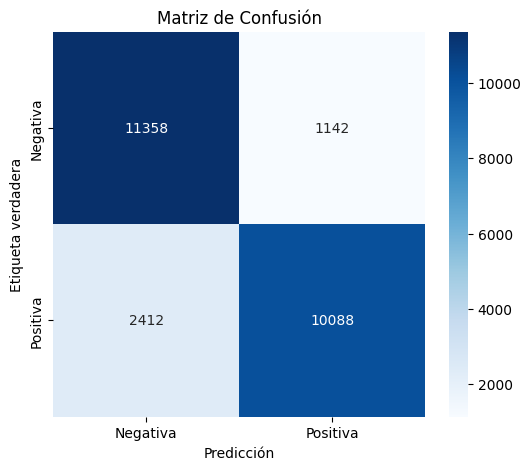

In [ ]:
# Predicciones (probabilidades)
y_pred_prob = transformer_model.predict([X_test_pad, X_test_pad])
# Convertir a clases (0 o 1)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Reporte de clasificación
print("📋 Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred, target_names=["Negativa", "Positiva"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativa", "Positiva"], yticklabels=["Negativa", "Positiva"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión")
plt.show()

/tmp/ipython-input-32-2417583913.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


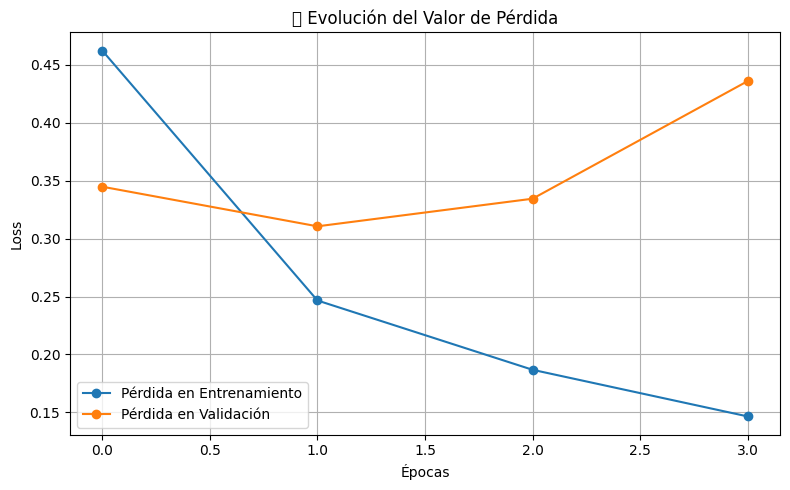

In [ ]:
# Gráfico del valor de pérdida durante el entrenamiento
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento', marker='o')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación', marker='o')
    plt.title('📉 Evolución del Valor de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamamos a la función
plot_loss(history)

In [ ]:
# Si estás en Google Colab, ejecuta esta celda para cargar el tablero de TensorBoard
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Transformer/Log

<IPython.core.display.Javascript object>

# Fase 7 predicciones

In [ ]:
# Reconstruye el modelo exactamente igual que durante el entrenamiento
# (con los bloques encoder, decoder, embeddings, pooling y demás definidos)

transformer_model.load_weights("/content/drive/MyDrive/Transformer/Checkpoint/best_model.h5")
print("✅ Modelo cargado correctamente.")

✅ Modelo cargado correctamente.


In [ ]:
sample_reviews = [
    "This movie was a masterpiece with stunning visuals and strong performances",
    "Absolutely terrible. I can't believe I wasted two hours on this",
    "It was okay, not bad but not great either",
    "One of the best films I've seen in years!",
    "The plot made no sense and the acting was wooden",
    "I laughed, I cried, and I loved every minute of it",
    "Completely overrated. Don't understand the hype",
    "An emotional rollercoaster with brilliant writing",
    "Boring and predictable from start to finish",
    "This is a bad movie"
]

In [ ]:
# Cargar diccionario de palabras
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["[PAD]"] = 0
word_index["[START]"] = 1
word_index["[UNK]"] = 2
word_index["[UNUSED]"] = 3

def encode_review(text, max_len=250):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = text.split()
    encoded = [1]  # [START]
    for word in tokens:
        encoded.append(word_index.get(word, 2))
    padded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    return padded

In [ ]:
print("🔍 PREDICCIONES DETALLADAS DEL MODELO TRANSFORMER:\n")

for i, review in enumerate(sample_reviews):
    encoded = encode_review(review, max_len=250)
    prediction = transformer_model.predict([encoded, encoded])[0][0]
    predicted_class = int(prediction >= 0.5)

    predicted_sentiment = "Positiva ✅" if predicted_class == 1 else "Negativa ❌"
    probability_percent = prediction * 100  # Convertimos a porcentaje

    print(f"{i+1}. Reseña: \"{review}\"\n")
    print(f"   🟩 Predicción del modelo: {predicted_sentiment}")
    print(f"   📊 Probabilidad: {probability_percent:.2f}%\n")


🔍 PREDICCIONES DETALLADAS DEL MODELO TRANSFORMER:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1. Reseña: "This movie was a masterpiece with stunning visuals and strong performances"

   🟩 Predicción del modelo: Positiva ✅
   📊 Probabilidad: 99.95%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2. Reseña: "Absolutely terrible. I can't believe I wasted two hours on this"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 0.26%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3. Reseña: "It was okay, not bad but not great either"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 1.18%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4. Reseña: "One of the best films I've seen in years!"

   🟩 Predicción del modelo: Positiva ✅
   📊 Probabilidad: 99.94%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5. Reseña: "The plot made no sense and the acting was wooden"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 0.15%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6. Reseña: "I laughed, I cried, and I loved every mi